# Q3 - Short Video Classification

## 1.Import the necessary libraries 

In [30]:
import subprocess
import os
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout

## 2. Use FFmpeg to extract key frames from videos, 1 frame per second

In [11]:
def extract_key_frames_ffmpeg(video_path, output_base_folder, frame_rate=1):
    """Extract key frames from a video using FFmpeg and save them to folders named after the video.

    Args:
        video_path (str): Path to the video file.
        output_base_folder (str): Base path to store all key frame folders.
        frame_rate (int, optional): The frequency of extracting key frames. Default is one frame per second.
    """
    video_name = os.path.basename(video_path).split('.')[0]
    output_folder = os.path.join(output_base_folder, video_name)
    
    # Create a folder for the video if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    output_filename = os.path.join(output_folder, "frame_%d.jpg")
    cmd = f"./ffmpeg -i {video_path} -vf fps={frame_rate} {output_filename}"
    
    # Run FFmpeg command to extract key frames
    subprocess.run(cmd, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)


def process_videos_with_ffmpeg(folder_path, output_folder, frame_rate=1):
    """Process all videos in a folder using FFmpeg and display a progress bar.

    Args:
        folder_path (str): Path to the folder containing video files.
        output_folder (str): Path to the folder to store key frames.
        frame_rate (int, optional): The frequency of extracting key frames. Default is one frame per second.
    """
    videos = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.mp4')]

    with tqdm(total=len(videos), desc="Processing Videos") as pbar:
        for video in videos:
            extract_key_frames_ffmpeg(video, output_folder, frame_rate)
            pbar.update(1)

In [12]:
# Paths to training and testing video folders
train_videos_path = '../Data_Q3/train_video'
test_videos_path = '../Data_Q3/test_video'

# Output folders for storing key frames
output_folder_train = '../Processed_Data_Q3/train_key_frames'
output_folder_test = '../Processed_Data_Q3/test_key_frames'

# Process training videos and save key frames
process_videos_with_ffmpeg(train_videos_path, output_folder_train)

# Process testing videos and save key frames
process_videos_with_ffmpeg(test_videos_path, output_folder_test)


Processing Videos: 100%|██████████| 562/562 [01:01<00:00,  9.12it/s]


## 3. Data Loading and Preprocessing

In [31]:
# Function to load labels from a tag file
def load_labels(tag_file_path):
    # Read the tag file into a DataFrame with columns 'video' and 'label'
    labels_df = pd.read_csv(tag_file_path, header=None, names=['video', 'label'])
    
    # Remove file extensions from the 'video' column
    labels_df['video'] = labels_df['video'].apply(lambda x: x.split('.')[0])
    
    return labels_df

# Function to load video frames
def load_video_frames(video_folder_path, labels_df=None, frame_size=(64, 64), max_frames=20, load_labels=True):
    X, y = [], []
    
    for folder in os.listdir(video_folder_path):
        folder_path = os.path.join(video_folder_path, folder)
        
        if not os.path.isdir(folder_path):
            continue

        frames = []
        for frame_file in sorted(os.listdir(folder_path))[:max_frames]:
            frame_path = os.path.join(folder_path, frame_file)
            img = cv2.imread(frame_path)
            img = cv2.resize(img, frame_size)
            frames.append(img)

        while len(frames) < max_frames:
            frames.append(np.zeros_like(frames[0]))  # Ensure all videos have the same number of frames

        X.append(frames)

        if load_labels and labels_df is not None:
            label = labels_df[labels_df['video'] == folder]['label'].values
            if len(label) > 0:
                y.append(label[0])
            else:
                y.append(-1)  # Use a placeholder for videos with no found labels

    X = np.array(X).astype('float32') / 255.0  # Normalize pixel values
    if load_labels:
        y = to_categorical(y)  # One-hot encode labels
        return X, y
    else:
        return X

# Specify the paths
tag_file_path = '../Data_Q3/tarin_tag.txt'  # Change to your tag.txt file path
train_key_frames_path = '../Processed_Data_Q3/train_key_frames'  # Change to your train_key_frames folder path

# Load labels from the tag file
labels_df = load_labels(tag_file_path)

# Load video frames along with labels
X, y = load_video_frames(train_key_frames_path, labels_df)

## 4. Model Building

In [32]:
# Function to build a 3D convolutional neural network model
def build_model(num_classes):
    model = Sequential()
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(20, 64, 64, 3)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Define the number of classes based on the shape of the labels
num_classes = y.shape[1]

# Build the model
model = build_model(num_classes)

# Compile the model with categorical cross-entropy loss and the Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 5. Model Training

In [33]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50015940)

# Fit the model to the training data and validate it on the testing data
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
52/52 [==============================] - 108s 2s/step - loss: 2.4784 - accuracy: 0.2515 - val_loss: 2.0637 - val_accuracy: 0.3366
Epoch 2/50
52/52 [==============================] - 104s 2s/step - loss: 2.0431 - accuracy: 0.3467 - val_loss: 1.8439 - val_accuracy: 0.4068
Epoch 3/50
52/52 [==============================] - 106s 2s/step - loss: 1.8518 - accuracy: 0.3945 - val_loss: 1.6965 - val_accuracy: 0.4649
Epoch 4/50
52/52 [==============================] - 106s 2s/step - loss: 1.6475 - accuracy: 0.4721 - val_loss: 1.5118 - val_accuracy: 0.4939
Epoch 5/50
52/52 [==============================] - 105s 2s/step - loss: 1.4971 - accuracy: 0.5303 - val_loss: 1.4980 - val_accuracy: 0.4843
Epoch 6/50
52/52 [==============================] - 107s 2s/step - loss: 1.3260 - accuracy: 0.5679 - val_loss: 1.4393 - val_accuracy: 0.5278
Epoch 7/50
52/52 [==============================] - 109s 2s/step - loss: 1.1253 - accuracy: 0.6352 - val_loss: 1.5639 - val_accuracy: 0.5036
Epoch 8/50
52

## 6. Model Evaluation

In [34]:
# Evaluate the trained model on the testing data
score = model.evaluate(X_test, y_test)

# Print the test loss and test accuracy
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')


13/13 [==============================] - 2s 187ms/step - loss: 2.6585 - accuracy: 0.6223
Test loss: 2.6585400104522705 / Test accuracy: 0.6222760081291199


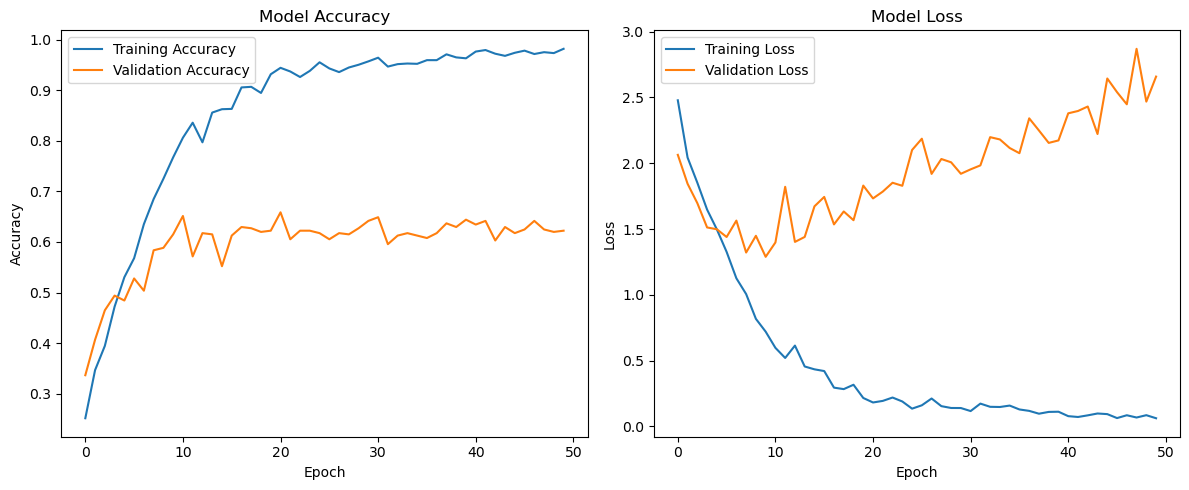

In [35]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Subplot for training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust subplot layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()


## 7. Model Prediction

In [36]:
test_key_frames_path = '../Processed_Data_Q3/test_key_frames' 

# Load test data using the same function as for training data, but without labels
X_test = load_video_frames(test_key_frames_path, load_labels=False)


In [37]:
# Use the trained model to make predictions on the test data
predictions = model.predict(X_test)

# Get the predicted labels by finding the index of the maximum probability in each prediction
predicted_labels = np.argmax(predictions, axis=1)


18/18 [==============================] - 3s 190ms/step


In [38]:
# Get the names of test videos by listing directories in the test key frames path
test_video_names = [folder for folder in os.listdir(test_key_frames_path) if os.path.isdir(os.path.join(test_key_frames_path, folder))]

# Create a DataFrame containing file names and predicted labels
results_df = pd.DataFrame({
    'file_name': [name + '.mp4' for name in test_video_names],  # Add '.mp4' extension to file names
    'label': predicted_labels
})

# Display the DataFrame
results_df


,file_name,label
0,602356487.mp4,9
1,838716540.mp4,5
2,897974621_70_80.mp4,2
3,879516906.mp4,3
4,748491221_220_230.mp4,7
...,...,...
557,543121627.mp4,9
558,872048877.mp4,3
559,501034834.mp4,12
560,837886335.mp4,10


In [39]:
# Save the DataFrame to a CSV file
results_df.to_csv('../Q3_output.csv', index=False)